In [26]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns
import math

sns.set(font_scale=1.4)

In [3]:
picks = pd.read_csv('picks.csv')

In this notebook we will be dealing with the picks dataset. 

This dataset has information about every match's pick/ban phase and so we can extract insights like what maps are most picked in what timeframe, which maps are removed the most, and a teams preferred map pick/ban in any given time period.

# Data Cleaning 

In [4]:
picks.head()

,date,team_1,team_2,inverted_teams,match_id,event_id,best_of,system,t1_removed_1,t1_removed_2,t1_removed_3,t2_removed_1,t2_removed_2,t2_removed_3,t1_picked_1,t2_picked_1,left_over
0,2020-03-18,TeamOne,Recon 5,1,2340454,5151,3,123412,Vertigo,Train,0.0,Nuke,Overpass,0.0,Dust2,Inferno,Mirage
1,2020-03-18,Rugratz,Bad News Bears,0,2340453,5151,3,123412,Dust2,Nuke,0.0,Mirage,Train,0.0,Vertigo,Inferno,Overpass
2,2020-03-18,New England Whalers,Station7,0,2340461,5243,1,121212,Mirage,Dust2,Vertigo,Nuke,Train,Overpass,0.0,0.0,Inferno
3,2020-03-17,Complexity,forZe,1,2340279,5226,3,123412,Inferno,Nuke,0.0,Overpass,Vertigo,0.0,Dust2,Train,Mirage
4,2020-03-17,Singularity,Endpoint,0,2340456,5247,3,123412,Train,Mirage,0.0,Nuke,Inferno,0.0,Overpass,Vertigo,Dust2


In [5]:
picks.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16035 entries, 0 to 16034
Data columns (total 17 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   date            16035 non-null  object
 1   team_1          16035 non-null  object
 2   team_2          16035 non-null  object
 3   inverted_teams  16035 non-null  int64 
 4   match_id        16035 non-null  int64 
 5   event_id        16035 non-null  int64 
 6   best_of         16035 non-null  object
 7   system          16035 non-null  int64 
 8   t1_removed_1    16035 non-null  object
 9   t1_removed_2    16035 non-null  object
 10  t1_removed_3    16035 non-null  object
 11  t2_removed_1    16035 non-null  object
 12  t2_removed_2    16035 non-null  object
 13  t2_removed_3    16035 non-null  object
 14  t1_picked_1     16035 non-null  object
 15  t2_picked_1     16035 non-null  object
 16  left_over       16035 non-null  object
dtypes: int64(4), object(13)
memory usage: 2.1+ MB


Check for missing data in the dataframe

<AxesSubplot:>

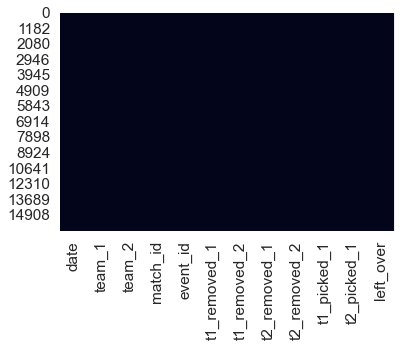

In [27]:
sns.heatmap(picks.isnull(), cbar=False)

This heatmap may be misleading. We may think that the data is clean since there are no null values, but the values in the columns may not be perfect, which we will see later on in this notebook.

In [7]:
picks['date'] = pd.to_datetime(picks['date'])

In [8]:
picks['best_of'].value_counts()

3            10142
1             5656
2              224
3.               3
of               3
3(LAN)           3
1(Online)        2
3(Online)        1
2(Online)        1
Name: best_of, dtype: int64

I only want to consider best of 3 matches as it will streamline the analysis and it is the most common type match-type in big tournaments (aside from best of 5 matches in grand finals).

In [9]:
picks.at[picks['best_of'] ==  '3.', 'best_of'] = '3'
picks.at[picks['best_of'] ==  'of', 'best_of'] = '3'
picks.at[picks['best_of'] ==  '3(LAN)', 'best_of'] = '3'
picks.at[picks['best_of'] ==  '3(Online)', 'best_of'] = '3'

picks = picks[picks['best_of'] == '3']

We can drop some columns that we will not need since we are only considering best of 3s.

In [10]:
picks.drop(['best_of', 't1_removed_3', 't2_removed_3', 'inverted_teams', 'system'], axis=1, inplace=True)

To make sure the other columns only have the values we want, we set a list of those values for the map related columns. 

In [11]:
maps = ['Mirage', 'Inferno', 'Train', 'Overpass', 'Nuke', 'Dust2', 'Cache', 'Cobblestone', 'Vertigo']
columns = ['t1_removed_1', 't1_removed_2', 't2_removed_1', 't2_removed_2', 't1_picked_1', 't2_picked_1', 'left_over']

for c in columns:
    picks.drop(picks[~picks[c].isin(maps)].index, inplace=True)

In [12]:
picks.head()

,date,team_1,team_2,match_id,event_id,t1_removed_1,t1_removed_2,t2_removed_1,t2_removed_2,t1_picked_1,t2_picked_1,left_over
0,2020-03-18,TeamOne,Recon 5,2340454,5151,Vertigo,Train,Nuke,Overpass,Dust2,Inferno,Mirage
1,2020-03-18,Rugratz,Bad News Bears,2340453,5151,Dust2,Nuke,Mirage,Train,Vertigo,Inferno,Overpass
3,2020-03-17,Complexity,forZe,2340279,5226,Inferno,Nuke,Overpass,Vertigo,Dust2,Train,Mirage
4,2020-03-17,Singularity,Endpoint,2340456,5247,Train,Mirage,Nuke,Inferno,Overpass,Vertigo,Dust2
5,2020-03-17,BIG,fnatic,2340397,5226,Train,Dust2,Nuke,Vertigo,Inferno,Overpass,Mirage


match_id and event_id have information that can be used to join this data do the other datasets. You can find my analysis on those in the other notebooks in this repository.

# Data Visualizations

To start off we will make some preliminary visualizations to see how the data looks and then we will answer some specific questions.

 ## *Note that even there there are 9 maps listed here, competitive CS:GO's map pool is set at 7 at a given time. Cache and Cobblestone were replaced with Nuke and Vertigo at seperate times.*

In a best of 3 match the map pick/veto system is as follows: 

> <br> Team 1 Veto, <br> Team 2 Veto, <br> <br> Team 1 Pick, <br> Team 2 Pick, <br> <br> Team 1 Veto, <br> Team 2 Veto, <br> <br> Final Map Left Over <br> 


The map pick/veto system is not consistently in this order, however it should not make a significant difference in our analysis of map picks and bans.

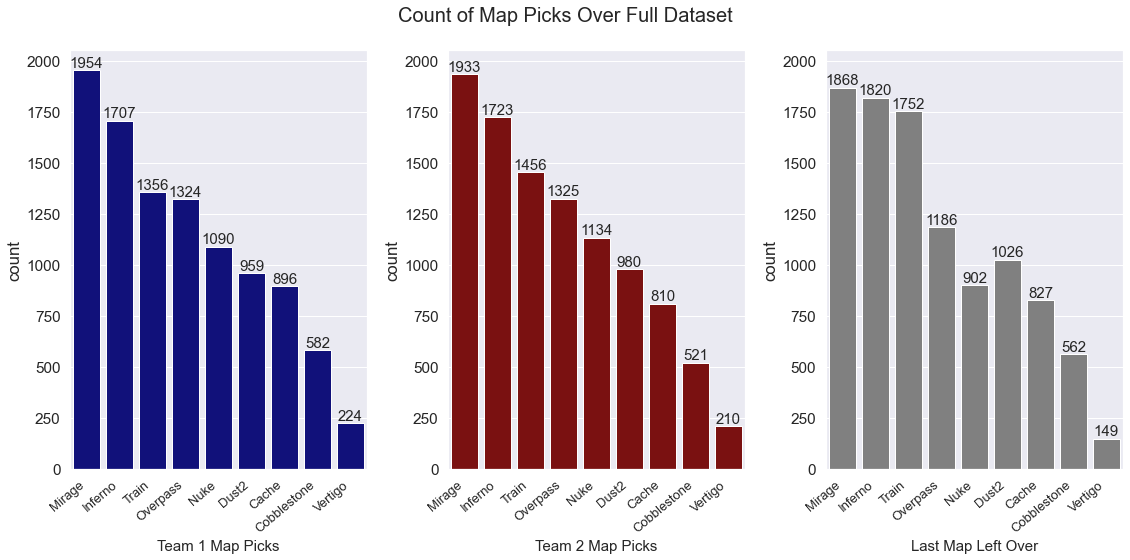

In [28]:
maps = ['Mirage', 'Inferno', 'Train', 'Overpass', 'Nuke', 'Dust2', 'Cache', 'Cobblestone', 'Vertigo']
sns.set_style('darkgrid')
f, ax = plt.subplots(1,3,figsize=(16,8), sharey=True)
f.suptitle('Count of Map Picks Over Full Dataset', y=.98, fontsize=20)

sns.countplot(x='t1_picked_1', data=picks, ax=ax[0], order=maps, color='darkblue')
ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=40, ha="right", fontsize=13)
ax[0].set_xlabel('Team 1 Map Picks', fontsize=15)
ax[0].bar_label(ax[0].containers[0], fontsize=15)

sns.countplot(x='t2_picked_1', data=picks, ax=ax[1], order=maps, color='darkred')
ax[1].set_xticklabels(ax[1].get_xticklabels(), rotation=40, ha="right", fontsize=13)
ax[1].set_xlabel('Team 2 Map Picks', fontsize=15)
ax[1].bar_label(ax[1].containers[0], fontsize=15)
ax[1].yaxis.set_tick_params(labelbottom=True)

sns.countplot(x='left_over', data=picks, ax=ax[2], order=maps, color='grey')
ax[2].set_xticklabels(ax[2].get_xticklabels(), rotation=40, ha="right", fontsize=13)
ax[2].set_xlabel('Last Map Left Over', fontsize=15)
ax[2].bar_label(ax[2].containers[0], fontsize=15)
ax[2].yaxis.set_tick_params(labelbottom=True)

plt.tight_layout()

plt.show()

To get some context of the maps and their release, let us look at the first appearance of the map in any of the map columns and how long they have been available to play.

In [14]:
d = {}
for m in maps:
    l_1 = []
    l_2 = []
    c = 0
    for col in columns:
        l_1.append(picks[picks[col] == m]['date'].min())
        l_2.append(picks[picks[col] == m]['date'].max())
    fa = np.min(l_1)
    la = np.max(l_2)
    lor = la - fa
    c = 0
    for p in picks.values:
        if m in p:
            c += 1

    d[m] = [fa, la, lor, c]

map_df = pd.DataFrame(data=d, index=['First Appearance', 'Last Appearance', 'Last - First', 'Count']).transpose()
map_df

,First Appearance,Last Appearance,Last - First,Count
Mirage,2016-04-14,2020-03-18,1434 days,10092
Inferno,2016-04-14,2020-03-18,1434 days,9378
Train,2016-04-14,2020-03-18,1434 days,10092
Overpass,2016-04-14,2020-03-18,1434 days,10092
Nuke,2016-07-22,2020-03-18,1335 days,10078
Dust2,2016-04-14,2020-03-18,1434 days,6981
Cache,2016-04-14,2019-07-14,1186 days,6903
Cobblestone,2016-04-14,2018-06-04,781 days,3839
Vertigo,2019-04-02,2020-03-18,351 days,3189


From this table we can contemplate many different questions/conclusions:
- Cache and Cobblestone stopped being a part of the main map pool (as far as the dataset goes into 2020).
- Mirage, Train, and Overpass have presence in every match.
- Inferno, Nuke, and Dust2 were out of the map pool and have been since reintroduced.


Now to look at the map bans and see the frequency of the maps that have been banned in the 1st and 2nd rotations

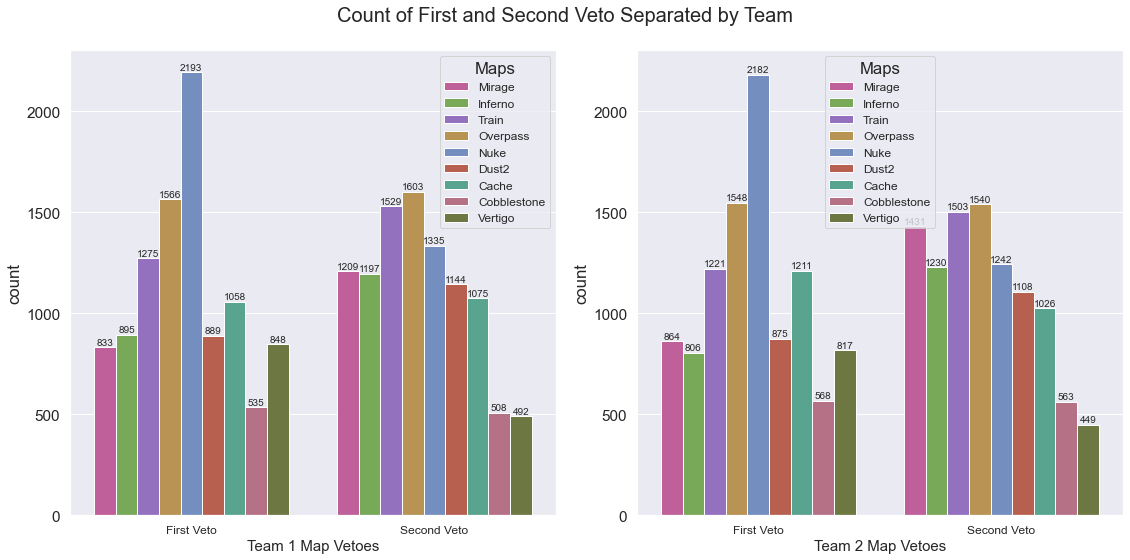

In [29]:
maps = ['Mirage', 'Inferno', 'Train', 'Overpass', 'Nuke', 'Dust2', 'Cache', 'Cobblestone', 'Vertigo']
f, ax = plt.subplots(1,2,figsize=(16,8), sharey=True)
f.suptitle('Count of First and Second Veto Separated by Team', y=.98, fontsize=20)

melt_df_1 = picks[['t1_removed_1', 't1_removed_2']]
melt_df_2 = picks[['t2_removed_1', 't2_removed_2']]

sns.countplot(x='variable', hue='value', data=pd.melt(melt_df_1), ax=ax[0], hue_order=maps, palette=["#cf509d","#74b64b","#9364cb","#c99743","#698acc","#ca543e","#4bb193","#c06680","#728039"])
ax[0].set_xlabel('Team 1 Map Vetoes', fontsize=15)
ax[0].legend(title='Maps', fontsize=12)
ax[0].set_xticklabels(['First Veto', 'Second Veto'], fontsize=12)
for container in ax[0].containers:
    ax[0].bar_label(container, fontsize=10)
ax[0].yaxis.set_tick_params(labelbottom=True)

sns.countplot(x='variable', hue='value', data=pd.melt(melt_df_2), ax=ax[1], hue_order=maps, palette=["#cf509d","#74b64b","#9364cb","#c99743","#698acc","#ca543e","#4bb193","#c06680","#728039"])
ax[1].set_xlabel('Team 2 Map Vetoes', fontsize=15)
ax[1].legend(loc='upper center', title='Maps', fontsize=12)
ax[1].set_xticklabels(['First Veto', 'Second Veto'], fontsize=12)
for container in ax[1].containers:
    ax[1].bar_label(container, fontsize=10)
ax[1].yaxis.set_tick_params(labelbottom=True)

plt.tight_layout()
plt.show()

From this plot we can see that in each rotation of the vetoes both teams have very similar picks and that the maps vetoed in each stage do differ, which may have to do with what maps were vetoed 
and picked in the first rotation.

Some takeaways from these visualizations:
- Mirage and Inferno are the most played maps and most popular map picks from 2016-2020, with Train and Overpass close behind.
- Nuke is by far the most popular first rotation map veto for btoh team 1 and team 2. 
- Dust2, Cache, Cobblestone, and Vertigo underperform in map picks/vetoes since they were not consistently included in the map pools of the tournaments that ran from 2016-2020.
- In the case of Vertigo, which was only added in 2019, we will look closer to the matches played from its introduction to where the data ends.

## Study of picks/bans post Vertigo's introduction into the map pool.

In [16]:
# Find the first date which Vertigo appears as a map veto, pick, or left over
picks[picks.isin(['Vertigo']).any(axis=1)]['date'].tail(1)

4712   2019-04-02
Name: date, dtype: datetime64[ns]

In [17]:
vertigo_df = picks[picks['date'] >= '2019-04-02']
vertigo_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3462 entries, 0 to 4712
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   date          3462 non-null   datetime64[ns]
 1   team_1        3462 non-null   object        
 2   team_2        3462 non-null   object        
 3   match_id      3462 non-null   int64         
 4   event_id      3462 non-null   int64         
 5   t1_removed_1  3462 non-null   object        
 6   t1_removed_2  3462 non-null   object        
 7   t2_removed_1  3462 non-null   object        
 8   t2_removed_2  3462 non-null   object        
 9   t1_picked_1   3462 non-null   object        
 10  t2_picked_1   3462 non-null   object        
 11  left_over     3462 non-null   object        
dtypes: datetime64[ns](1), int64(2), object(9)
memory usage: 351.6+ KB


In [18]:
vertigo_df[vertigo_df.isin(['Cobblestone']).any(axis=1)]

,date,team_1,team_2,match_id,event_id,t1_removed_1,t1_removed_2,t2_removed_1,t2_removed_2,t1_picked_1,t2_picked_1,left_over


Cobblestone has stopped being played at this point but we will keep it as a column to keep consistency with our visualizations

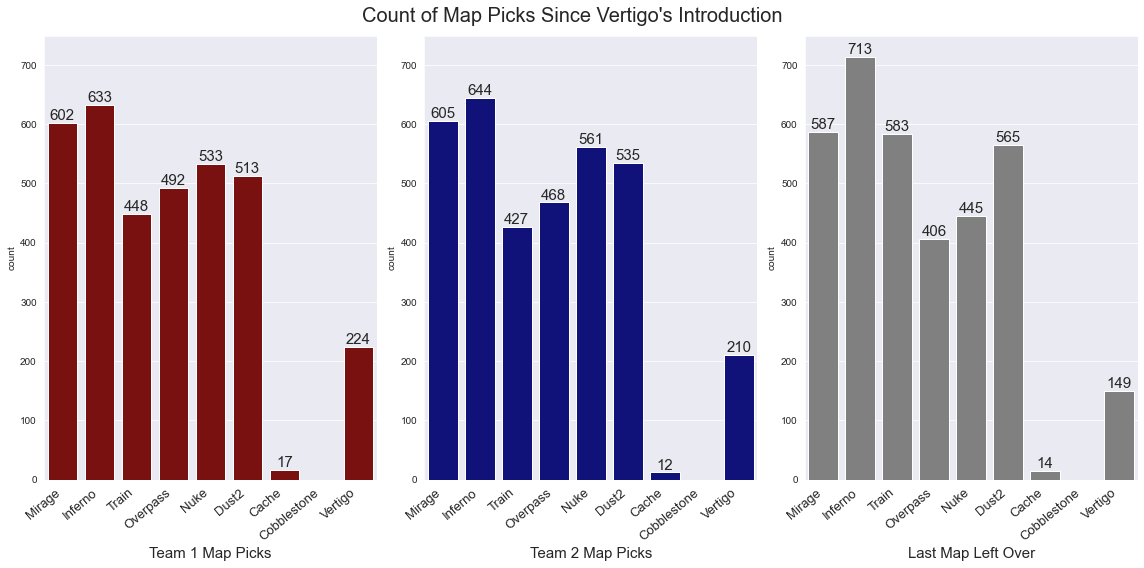

In [19]:
maps = ['Mirage', 'Inferno', 'Train', 'Overpass', 'Nuke', 'Dust2', 'Cache', 'Cobblestone', 'Vertigo']
f, ax = plt.subplots(1,3,figsize=(16,8), sharey=True)
f.suptitle("Count of Map Picks Since Vertigo's Introduction", y=.98, fontsize=20)

sns.countplot(x='t1_picked_1', data=vertigo_df, ax=ax[0], order=maps, color='darkred')
ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=40, ha="right", fontsize=13)
ax[0].set_xlabel('Team 1 Map Picks', fontsize=15)
ax[0].bar_label(ax[0].containers[0], fontsize=15)
ax[0].yaxis.set_tick_params(labelbottom=True)

sns.countplot(x='t2_picked_1', data=vertigo_df, ax=ax[1], order=maps, color='darkblue')
ax[1].set_xticklabels(ax[1].get_xticklabels(), rotation=40, ha="right", fontsize=13)
ax[1].set_xlabel('Team 2 Map Picks', fontsize=15)
ax[1].bar_label(ax[1].containers[0], fontsize=15)
ax[1].yaxis.set_tick_params(labelbottom=True)

sns.countplot(x='left_over', data=vertigo_df, ax=ax[2], order=maps, color='grey')
ax[2].set_xticklabels(ax[2].get_xticklabels(), rotation=40, ha="right", fontsize=13)
ax[2].set_xlabel('Last Map Left Over', fontsize=15)
ax[2].bar_label(ax[2].containers[0], fontsize=15)
ax[2].yaxis.set_tick_params(labelbottom=True)

plt.tight_layout()
plt.show()

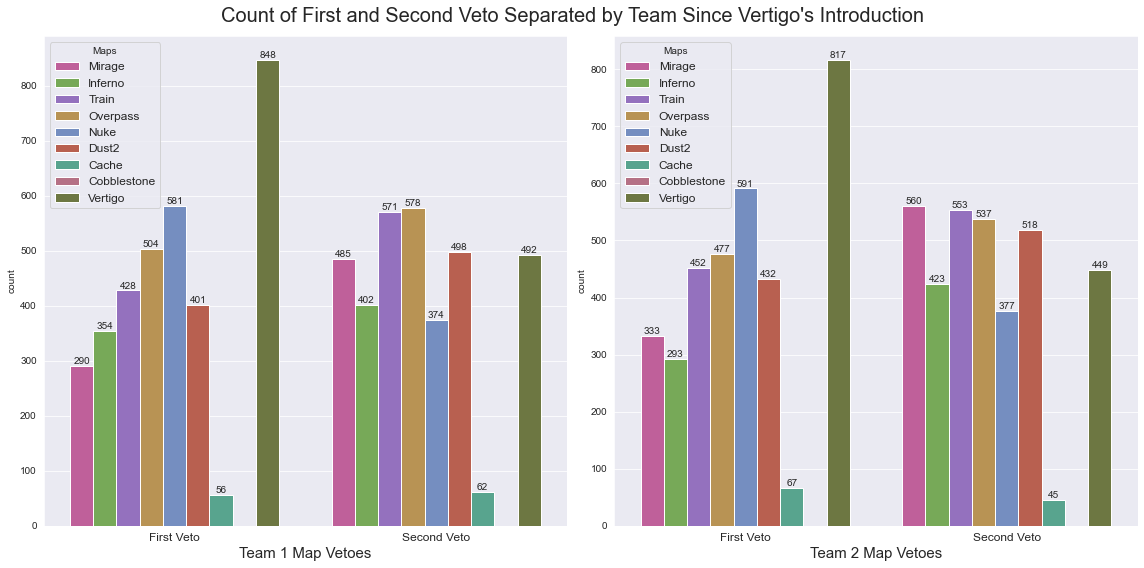

In [20]:
maps = ['Mirage', 'Inferno', 'Train', 'Overpass', 'Nuke', 'Dust2', 'Cache', 'Cobblestone', 'Vertigo']
f, ax = plt.subplots(1,2,figsize=(16,8))
f.suptitle("Count of First and Second Veto Separated by Team Since Vertigo's Introduction", y=.98, fontsize=20)
melt_df_1 = vertigo_df[['t1_removed_1', 't1_removed_2']]
melt_df_2 = vertigo_df[['t2_removed_1', 't2_removed_2']]

sns.countplot(x='variable', hue='value', data=pd.melt(melt_df_1), ax=ax[0], hue_order=maps, palette=["#cf509d","#74b64b","#9364cb","#c99743","#698acc","#ca543e","#4bb193","#c06680","#728039"])
ax[0].set_xlabel('Team 1 Map Vetoes', fontsize=15)
ax[0].legend(title='Maps', fontsize=12)
ax[0].set_xticklabels(['First Veto', 'Second Veto'], fontsize=12)
for container in ax[0].containers:
    ax[0].bar_label(container, fontsize=10)
ax[0].yaxis.set_tick_params(labelbottom=True)

sns.countplot(x='variable', hue='value', data=pd.melt(melt_df_2), ax=ax[1], hue_order=maps, palette=["#cf509d","#74b64b","#9364cb","#c99743","#698acc","#ca543e","#4bb193","#c06680","#728039"])
ax[1].set_xlabel('Team 2 Map Vetoes', fontsize=15)
ax[1].legend(title='Maps', fontsize=12)
ax[1].set_xticklabels(['First Veto', 'Second Veto'], fontsize=12)
for container in ax[1].containers:
    ax[1].bar_label(container, fontsize=10)
ax[1].yaxis.set_tick_params(labelbottom=True)

plt.tight_layout()
plt.show()

It is obvious that once Vertigo was introduced it became the most vetoed map by far. A reason for this could be that teams do not want to practice and prepare a new map, as they may not feel comfortable playing on it, especially against teams who have the early reads on it.

I wrote a function that will return a dataframe of the rolling sum of frequency of a map in a specified column in a given timeframe.

In [21]:
def plot_maps(date_range: list = None, column='t1_picked_1'):
    """ Plot column frequency by a date range. Default will be team 1 map picks with the full dataset.
    """
    assert column in ['t1_removed_1', 't1_removed_2', 't2_removed_1', 't2_removed_2', 't1_picked_1', 't2_picked_2', 'left_over']
    new_df = pd.DataFrame(None, columns=['Mirage', 'Inferno', 'Train', 'Overpass', 'Nuke', 'Dust2', 'Cache', 'Cobblestone', 'Vertigo'])
    if date_range is None:
        for index, row in picks.sort_values(by='date',ascending=True).iterrows():
            map_pick = row[column]
            date = row['date']
            if math.isnan(new_df[map_pick].max()):
                new_df.loc[date, map_pick] = 1
            else:
                new_df.loc[date, map_pick] = new_df[map_pick].max() + 1
    else:
        df = picks[(picks['date'] > date_range[0]) & (picks['date'] < date_range[1])].sort_values(by='date',ascending=True)
        for index, row in df.sort_values(by='date',ascending=True).iterrows():
            map_pick = row[column]
            date = row['date']
            if math.isnan(new_df[map_pick].max()):
                new_df.loc[date, map_pick] = 1
            else:
                new_df.loc[date, map_pick] = new_df[map_pick].max() + 1
    return new_df

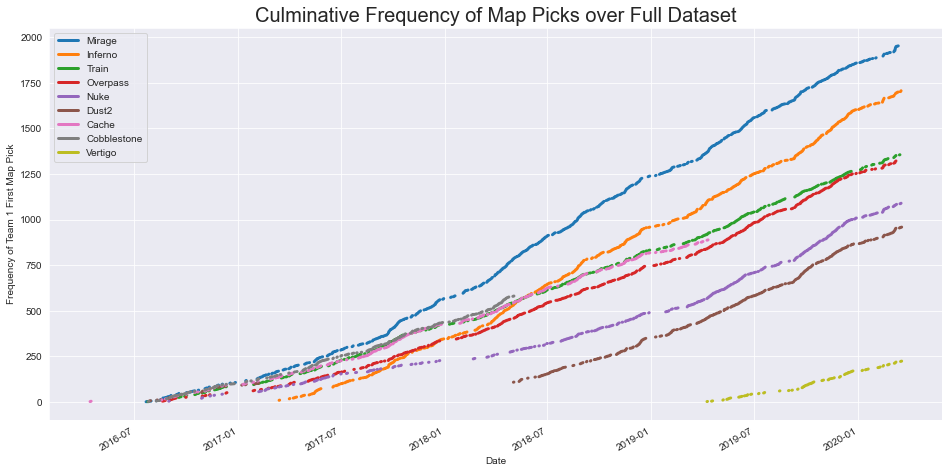

In [25]:
df1 = plot_maps()
df1.plot(figsize=(16,8), lw=3, ylabel = 'Frequency of Team 1 First Map Pick', xlabel='Date', fontsize=10)
plt.title("Culminative Frequency of Map Picks over Full Dataset", fontsize=20)
plt.show()

In [23]:
df2 = plot_maps(date_range=['2019-04-02', '2020-03-18'], column='t1_removed_1')

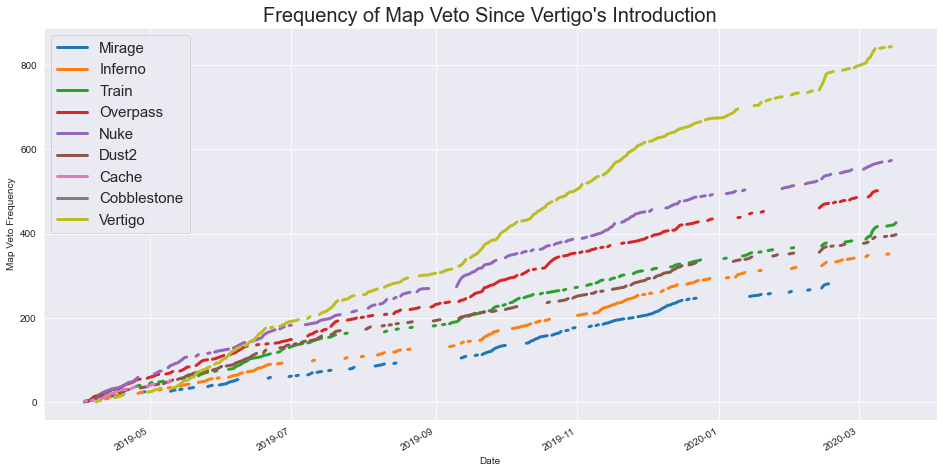

In [24]:
df2.plot(figsize=(16,8), lw=3, ylabel= 'Map Veto Frequency', xlabel='Date', fontsize=10)
plt.legend(prop={'size': 15})
plt.title("Frequency of Map Veto Since Vertigo's Introduction", fontsize=20)
plt.show()

Final takeaways from the picks dataset:
- In 2019 and 2020 Vertigo dominates the first map veto, this is because it was a new map introduced into the map pool and teams generally did not want to play on it.
- Note that the data from 2020 is only up until March, otherwise the bulk of the games played were between 2017 and the end of the dataset March 2020.
- Mirage and Inferno seem to be the most favoured maps that the teams want to play on.